In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use('classic')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
gpytorch.settings.cholesky_max_tries._set_value(100)

In [6]:
from pydap.client import open_url
raw_dataset = open_url('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46221/46221h2022.nc')

In [11]:
wave_height = raw_dataset['wave_height'].data[0]
time_ = raw_dataset['wave_height'].data[1]

In [31]:
wave_data = pd.DataFrame(time_, columns = ['Time'])
wave_height = np.ravel(wave_height)

wave_data['Wave Height'] = wave_height
wave_data.set_index('Time')
wave_data


,Time,Wave Height
0,1640996760,2.25
1,1640998560,2.22
2,1641000360,2.45
3,1641002160,2.24
4,1641003960,2.40
...,...,...
11640,1661982960,0.92
11641,1661984760,0.94
11642,1661986560,1.06
11643,1661988360,1.11


In [3]:
#wave_data['WVHT'] = wave_data['WVHT'].astype(float)


In [4]:
#wave_data = wave_data.reindex(index=wave_data.index[::-1])


# Data Setup

In [43]:



y = torch.tensor(wave_data['Wave Height'].values.astype(np.float32)).cuda()
X = torch.tensor(wave_data['Time'].values.astype(np.float32)).cuda()
X = X.reshape(-1,1)

# Standardizze
X = (X - X.mean(0)) / X.std(0)

y = y - torch.min(y)
y = 2 * (y / torch.max(y)) - 1

# Training vs test
from math import floor

train_n = int(floor(0.7 * len(X)))
train_x = X[:train_n].contiguous().cuda()
train_y = y[:train_n].contiguous().cuda()

test_x = X[train_n:].contiguous().cuda()
test_y = y[train_n:].contiguous().cuda()

In [44]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, generator = torch.Generator(device='cuda'))

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, generator = torch.Generator(device='cuda'))


# Function for Training

In [45]:

def train_and_test_approximate_gp(model_cls, kernel, num_epochs = 100):
    start_time = time.time()
    inducing_points = torch.randn(128, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    model = model_cls(inducing_points, kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.numel())
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
    optimizer.param_groups[0]['capturable'] = True

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    # Training
    model.train()
    likelihood.train()
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc=f"Training {model_cls.__name__}")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            epochs_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()


    # Testing
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.]).cuda()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean])
    means = means[1:]
    error = torch.mean(torch.abs(means - test_y))
    print(f"Test {model_cls.__name__} MAE: {error.item()}")
    print("--- %s seconds ---" % (time.time() - start_time))

    return model, likelihood



In [46]:
from gpytorch.kernels import PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel

from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal



In [47]:
kernel = (
        #ScaleKernel(AR2Kernel()) +
        #ScaleKernel(MinKernel()) +
        ScaleKernel(RBFKernel()) +
        ScaleKernel(RBFKernel()*PeriodicKernel())
        )



likelihood = gpytorch.likelihoods.GaussianLikelihood()



In [48]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [49]:
m1, l1 = train_and_test_approximate_gp(StandardApproximateGP, kernel, num_epochs=100)
m2, l2 = train_and_test_approximate_gp(MeanFieldApproximateGP, kernel, num_epochs=100)
m3, l3 = train_and_test_approximate_gp(MAPApproximateGP, kernel, num_epochs=100)
m4, l4 = train_and_test_approximate_gp(OrthDecoupledApproximateGP, kernel, num_epochs=100)

Training StandardApproximateGP:   0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda3\envs\MortKernel-gpytorch\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Test StandardApproximateGP MAE: 0.13517361879348755
--- 99.01616764068604 seconds ---
Test MeanFieldApproximateGP MAE: 0.14399078488349915
--- 85.15123724937439 seconds ---
Test MAPApproximateGP MAE: 0.14391687512397766
--- 79.93795156478882 seconds ---
Test OrthDecoupledApproximateGP MAE: 0.163857102394104
--- 209.15783548355103 seconds ---


Training MeanFieldApproximateGP:   0%|          | 0/100 [00:00<?, ?it/s]

Training MAPApproximateGP:   0%|          | 0/100 [00:00<?, ?it/s]

Training OrthDecoupledApproximateGP:   0%|          | 0/100 [00:00<?, ?it/s]

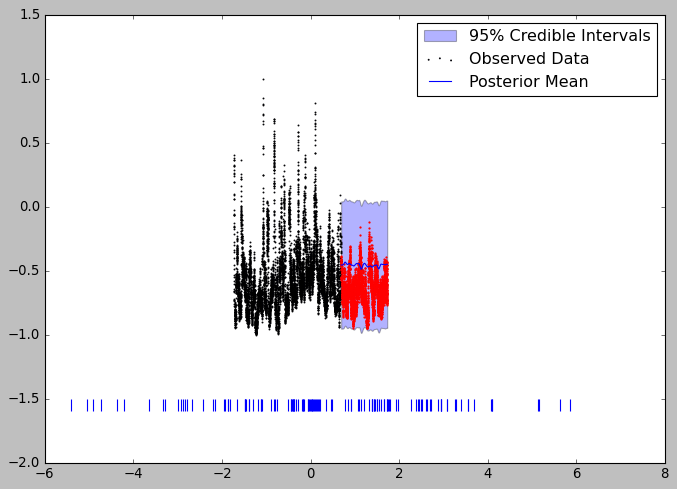

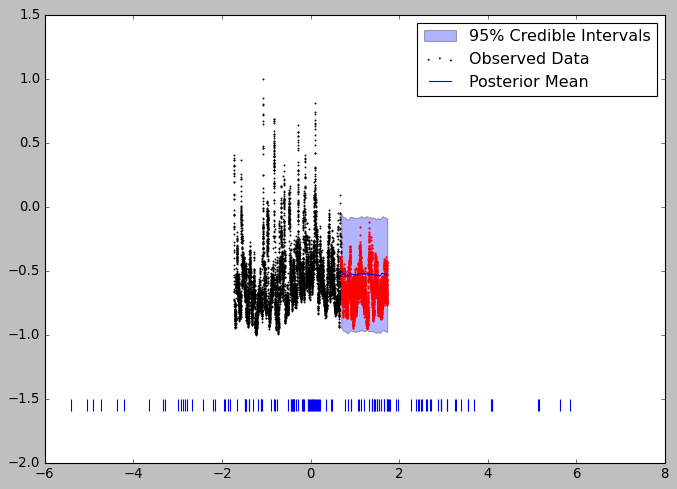

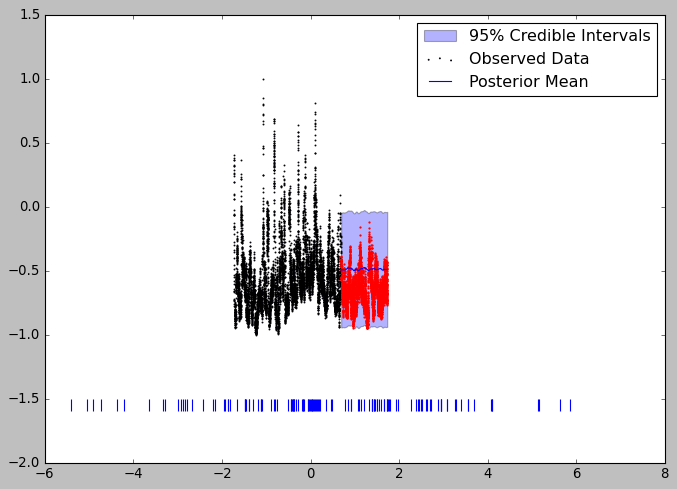

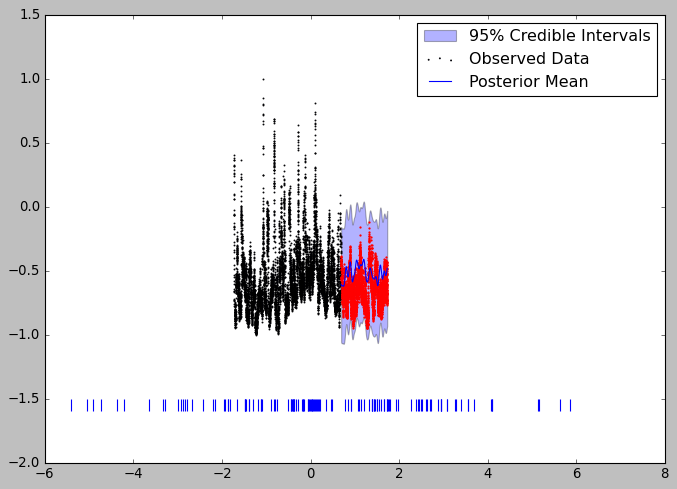

In [50]:
pairs = [[m1, l1], [m2, l2], [m3, l3], [m4, l4]]

for pair in pairs:
    model = pair[0]
    likelihood = pair[1]

    model.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].detach().cpu().numpy(),
                    lower.detach().cpu().numpy(),
                    upper.detach().cpu().numpy(), alpha=0.3)
    # Plot training data as black stars
    ax.scatter(train_x[:,0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
    #ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
    #           np.zeros(500)+1, s=0.5)
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')
    ax.scatter(test_x[:,0].detach().cpu().numpy(),
               test_y.detach().cpu().numpy(),
               s=1, color="red")

    ax.vlines(m1.variational_strategy.inducing_points.detach().cpu().numpy(), ymin = -1.6, ymax = -1.5)


    #ax.set_ylim([0, 1.5])
    #ax.patch.set_facecolor('green')
    #ax.patch.set_alpha(.1)
    ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])
